### Import libraries

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import coint, adfuller
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
from sklearn.preprocessing import MinMaxScaler
import warnings

warnings.filterwarnings("ignore")

### Check for stationarity
Time series are stationary when the parameters of the data generating process do not change over time.

Source: Integration_Cointegration_and_Stationarity by Quantopian

<Axes: >

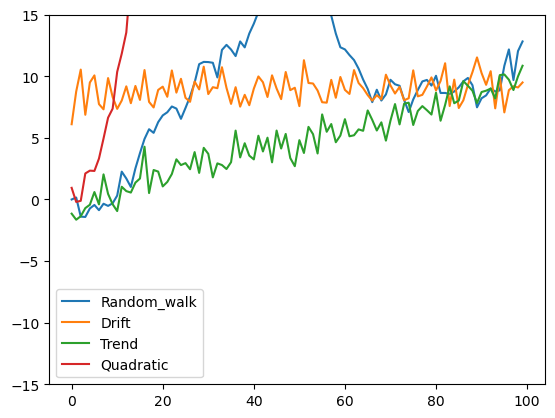

In [ ]:
def generate_datapoint(params):
    mu = params[0]
    sigma = params[1]
    return np.random.normal(mu, sigma)


# Set the number of datapoints
T = 100
ts = pd.DataFrame(np.zeros((T,4)),columns=["Random_walk","Drift","Trend","Quadratic"],index=range(T))

drift_params = (9, 1)
ts.loc[0,"Drift"] = generate_datapoint(drift_params)
trend_params = (0*0.1, 1)
ts.loc[0,"Trend"] = generate_datapoint(trend_params)
quad_trend_params = (0**2*0.1, 1)
ts.loc[0,"Quadratic"] = generate_datapoint(quad_trend_params)

for t in range(1,T):
    # Now the parameters are dependent on time
    # Specifically, the mean of the series changes over time
    rw_params = (0, 1)
    ts.loc[t,"Random_walk"] = ts.loc[t-1,"Random_walk"] + generate_datapoint(rw_params)
    drift_params = (9, 1)
    ts.loc[t,"Drift"] = generate_datapoint(drift_params)
    trend_params = (t*0.1, 1)
    ts.loc[t,"Trend"] = generate_datapoint(trend_params)
    quad_trend_params = (t**2*0.1, 1)
    ts.loc[t,"Quadratic"] = generate_datapoint(quad_trend_params)
    #! sin_params = (np.sin(t), 1) is mean reverting but is not stationary!

ts.plot(ylim=(-15,15))

Perform a unit root test using the Augmented Dickey-Fuller (ADF) test to determine whether a time series is stationary or not.

A cyclic movement of the mean will be very difficult to tell apart from random noise. In practice on noisy data and limited sample size it can be hard to determine if a series is stationary and whether any drift is random noise or part of a trend.

![alt text](ADFTests.png)

In [2]:
adftests_dict = {
    "c" : "drift",
    "ct" : "drift and trend",
    "ctt" : "constant and quadratic trend",
    "n" : "no constant and no trend"
}
def ADFTest(series, regression = "c", significance_level=0.01, CointTest=False):

    result = adfuller(series, regression=regression, maxlag=1)
    
    output = pd.Series(
        result[0:4],
        index=["ADF Statistic", "p-value", "Lags Used", "Observations Used"],
    )
    print(f"ADF results of {series.name} series:\n{output.to_string()} \nDickey Fuller Critical Values:")

    critical_values1 = result[4]
    for key, value in critical_values1.items():
        print(f"    {key}: {value:.4f}")

    if CointTest:
        if result[1] < significance_level:
            print(
                "\nThe series is stationary. It suggests the presence of a cointegrating relationship between the linear combination of the time series over the same timeframe."
            )
        else:
            print("\nThe series is nonstationary. The linear combination of the time series is non-cointegrated over the same timeframe.")
    
    else:
        if result[1] < significance_level:
            print(f"\nThe time series is {adftests_dict[regression]} stationary.\n")
        else:
            print(f"\nThe time series is {adftests_dict[regression]} nonstationary.\n")

In [85]:
ADFTest(ts.loc[:,"Random_walk"],regression = "c", significance_level=0.01)
ADFTest(ts.loc[:,"Drift"],regression = "c", significance_level=0.01)
ADFTest(ts.loc[:,"Trend"],regression = "ct", significance_level=0.01)
ADFTest(ts.loc[:,"Quadratic"],regression = "ctt", significance_level=0.01)

ADF results of Random_walk series:
ADF Statistic        -1.728455
p-value               0.416514
Lags Used             0.000000
Observations Used    99.000000 
Dickey Fuller Critical Values:
    1%: -3.4982
    5%: -2.8912
    10%: -2.5826

The time series is drift nonstationary.

ADF results of Drift series:
ADF Statistic       -1.139207e+01
p-value              8.022854e-21
Lags Used            0.000000e+00
Observations Used    9.900000e+01 
Dickey Fuller Critical Values:
    1%: -3.4982
    5%: -2.8912
    10%: -2.5826

The time series is drift stationary.

ADF results of Trend series:
ADF Statistic       -1.033775e+01
p-value              4.552341e-16
Lags Used            0.000000e+00
Observations Used    9.900000e+01 
Dickey Fuller Critical Values:
    1%: -4.0533
    5%: -3.4558
    10%: -3.1536

The time series is drift and trend stationary.

ADF results of Quadratic series:
ADF Statistic       -1.073418e+01
p-value              9.121467e-17
Lags Used            0.000000e+00
Obs

### IMPORTANT NOTE
As always, you should not naively assume that because a time series is stationary in the past it will continue to be stationary in the future. Tests for consistency of stationarity such as cross validation and out of sample testing are necessary. This is true of any statistical property, we just reiterate it here. Returns may also go in and out of stationarity, and may be stationary or non-stationary depending on the timeframe and sampling frequency.

Even using a returns forecasting model to forecast price can be tricky, as any error in the returns forecast will be magnified over time.

## Download two stocks data 

In [3]:
start_date = "2017-01-01"
end_date = "2019-01-01"

stock1 = yf.Ticker("KO")  #
stock1_data = stock1.history(interval="1d", start=start_date, end=end_date)

stock2 = yf.Ticker("PEP")  # If we use the ticker 'JPM' -> no cointegration.
stock2_data = stock2.history(interval="1d", start=start_date, end=end_date)

In [4]:
stock1_close = stock1_data["Close"]
stock2_close = stock2_data["Close"]

### Plot the two stocks

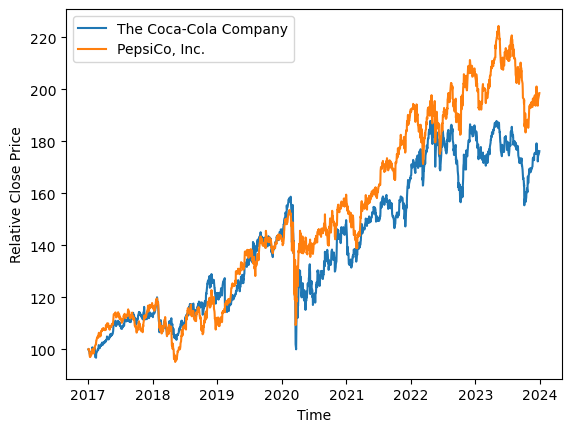

In [6]:
stock1_close_relative = stock1_close / stock1_close[0] * 100
stock2_close_relative = stock2_close / stock2_close[0] * 100
plt.plot(stock1_close_relative, label=stock1.info["longName"])
plt.plot(stock2_close_relative, label=stock2.info["longName"])

plt.xlabel("Time")
plt.ylabel("Relative Close Price")
plt.legend()
plt.show()

In [15]:
ADFTest(stock1_close, regression = "ctt", significance_level=0.01)
ADFTest(stock2_close, regression = "ctt", significance_level=0.01)

ADF results of Close series:
ADF Statistic         -2.575966
p-value                0.525646
Lags Used              1.000000
Observations Used    500.000000 
Dickey Fuller Critical Values:
    1%: -4.3945
    5%: -3.8443
    10%: -3.5606

The time series is constant and quadratic trend nonstationary.

ADF results of Close series:
ADF Statistic         -2.354174
p-value                0.650828
Lags Used              0.000000
Observations Used    501.000000 
Dickey Fuller Critical Values:
    1%: -4.3944
    5%: -3.8442
    10%: -3.5606

The time series is constant and quadratic trend nonstationary.



# Mean Reversion

### Moving Average ratio

In [17]:
stock1_mr = pd.DataFrame(stock1_close)

ma = 21

stock1_mr['Returns'] = np.log(stock1_close).diff()

# Calculate the moving average
stock1_mr['MA'] = stock1_close.rolling(ma).mean()

# Calculate the moving average ratio
stock1_mr['MA_Ratio'] = stock1_close / stock1_mr['MA']
stock1_mr.dropna(inplace=True)

In [18]:
ADFTest(stock1_mr["MA_Ratio"], significance_level=0.01) 

ADF results of MA_Ratio series:
ADF Statistic         -5.036081
p-value                0.000019
Lags Used              1.000000
Observations Used    480.000000 
Dickey Fuller Critical Values:
    1%: -3.4440
    5%: -2.8676
    10%: -2.5700

The time series is drift stationary.



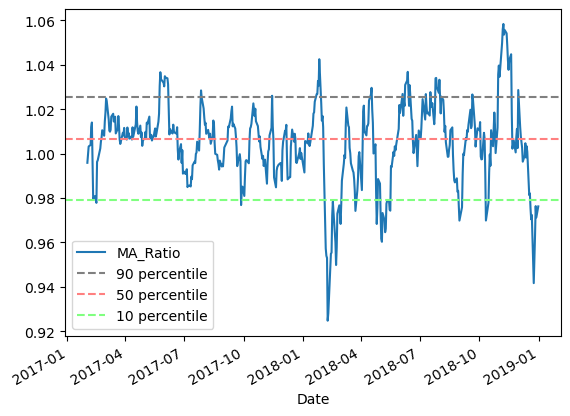

In [20]:
percentiles = [10, 50, 90]
p = np.percentile(stock1_mr["MA_Ratio"], percentiles)

stock1_mr["MA_Ratio"].plot()
plt.axhline(p[-1], c= (.5,.5,.5), ls='--',label=f"{percentiles[-1]} percentile")
plt.axhline(p[1], c= (1,.5,.5), ls='--',label=f"{percentiles[1]} percentile")
plt.axhline(p[0], c= (.5,1,.5), ls='--',label=f"{percentiles[0]} percentile")
plt.legend();

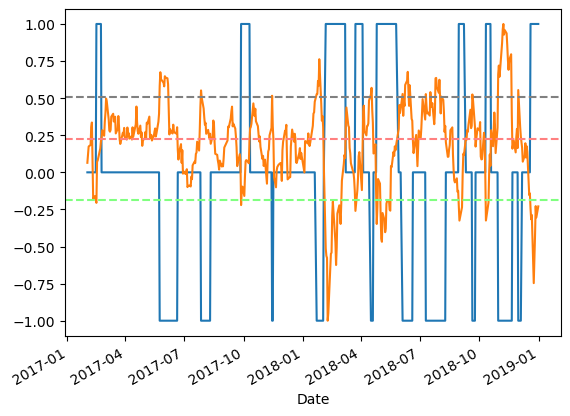

In [21]:
short = p[-1]
long = p[0]
exit = p[1]
stock_1 = stock1_mr.copy()

# Exit at the mean
stock_1["Difference"] = stock_1["MA_Ratio"] - exit
stock_1["Position"] = np.where(stock_1["Difference"] * stock_1["Difference"].shift(1) < 0, 0, np.nan)

# Short and Long
stock_1["Position"] = np.where(stock_1["MA_Ratio"] >= short, -1, stock_1["Position"])
stock_1["Position"] = np.where(stock_1["MA_Ratio"] <= long, 1, stock_1["Position"] )

stock_1["Position"] = stock_1["Position"].ffill().fillna(0)

stock_1["Position"].plot()

plt.plot(stock_1["Position"].index, MinMaxScaler((-1,1)).fit_transform(stock_1['MA_Ratio'].values.reshape(-1, 1)))
# stock1_mr['Exit'].plot()
t = np.percentile(MinMaxScaler((-1,1)).fit_transform(stock_1['MA_Ratio'].values.reshape(-1, 1)), percentiles)
plt.axhline(t[-1], c= (.5,.5,.5), ls='--',label=f"{percentiles[-1]} percentile")
plt.axhline(t[1], c= (1,.5,.5), ls='--',label=f"{percentiles[1]} percentile")
plt.axhline(t[0], c= (.5,1,.5), ls='--',label=f"{percentiles[0]} percentile");

#### Another way to generate signals

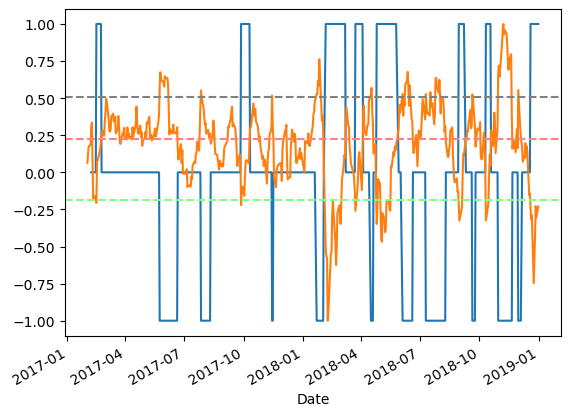

In [22]:
stock1_mr["Position"] = np.where(stock1_mr["MA_Ratio"] > short, -1, np.nan)
stock1_mr["Position"] = np.where(stock1_mr["MA_Ratio"] < long, 1, stock1_mr["Position"] )

stock1_mr['Short_Position'] = np.where((stock1_mr['MA_Ratio'] < exit) & (stock1_mr["MA_Ratio"] >= long), 0, stock1_mr['Position'])
stock1_mr['Short_Position'][stock1_mr['Short_Position'] > 0] = 0
stock1_mr["Short_Position"] = stock1_mr["Short_Position"].ffill()

stock1_mr['Long_Position'] = np.where((stock1_mr['MA_Ratio'] > exit) & (stock1_mr["MA_Ratio"] <= short), 0, stock1_mr['Position'])
stock1_mr['Long_Position'][stock1_mr['Long_Position'] < 0] = 0
stock1_mr["Long_Position"] = stock1_mr["Long_Position"].ffill()
stock1_mr["Position"] = stock1_mr["Long_Position"] + stock1_mr["Short_Position"]
stock1_mr["Position"].plot()


plt.plot(stock1_mr["Position"].index, MinMaxScaler((-1,1)).fit_transform(stock1_mr['MA_Ratio'].values.reshape(-1, 1)))
# stock1_mr['Exit'].plot()
t = np.percentile(MinMaxScaler((-1,1)).fit_transform(stock1_mr['MA_Ratio'].values.reshape(-1, 1)), percentiles)
plt.axhline(t[-1], c= (.5,.5,.5), ls='--',label=f"{percentiles[-1]} percentile")
plt.axhline(t[1], c= (1,.5,.5), ls='--',label=f"{percentiles[1]} percentile")
plt.axhline(t[0], c= (.5,1,.5), ls='--',label=f"{percentiles[0]} percentile");

Sharpe Ratio: 1.1789410422068232
Correlation between strategies: 0.18921568058903196


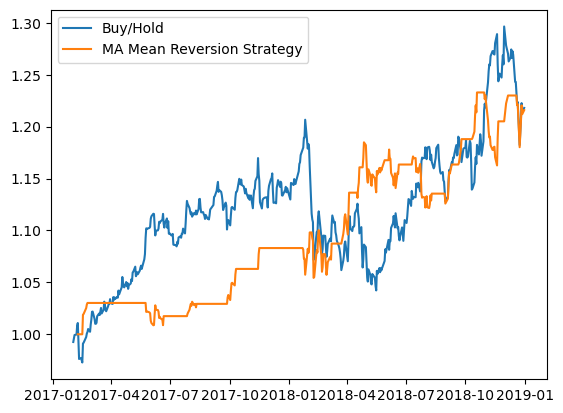

In [23]:
stock1_mr['MAMR_Return'] = stock1_mr['Returns'] * stock1_mr["Position"].shift()
plt.plot(np.exp(stock1_mr['Returns'].dropna()).cumprod(), label='Buy/Hold')
plt.plot(np.exp(stock1_mr['MAMR_Return'].dropna()).cumprod(), label='MA Mean Reversion Strategy')
plt.legend();
print("Sharpe Ratio:",(stock1_mr['MAMR_Return'].dropna().mean()* np.sqrt(252)) / stock1_mr['MAMR_Return'].dropna().std())
print("Correlation between strategies:", stock1_mr['MAMR_Return'].dropna().corr(stock1_mr['Returns'].dropna()))

### Linear Regression

In [24]:
stock1_lr = stock1_mr.drop(columns=['MA', 'MA_Ratio', 'Position', 'MAMR_return', 'Long_Position', 'Short_Position', 'MAMR_Return'], errors='ignore')
stock1_lr

,Close,Returns
Date,,
2017-02-01 00:00:00-05:00,31.794098,-0.007485
2017-02-02 00:00:00-05:00,31.901974,0.003387
2017-02-03 00:00:00-05:00,32.009853,0.003376
2017-02-06 00:00:00-05:00,32.025257,0.000481
2017-02-07 00:00:00-05:00,32.287254,0.008148
...,...,...
2018-12-24 00:00:00-05:00,37.872845,-0.034431
2018-12-26 00:00:00-05:00,38.680405,0.021099
2018-12-27 00:00:00-05:00,39.166584,0.012491


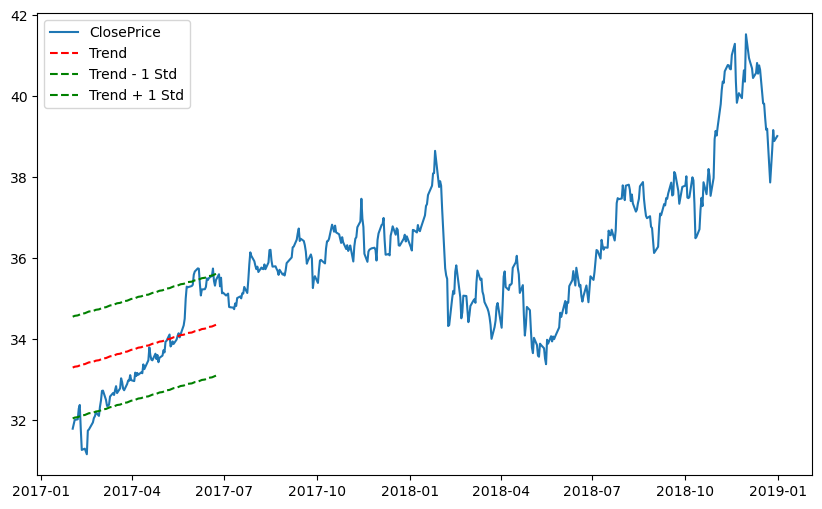

In [25]:
# Create a time variable
time = np.arange(1, len(stock1_lr) + 1)
stock1_lr['Time'] = time

# Perform linear regression using statsmodels
X = sm.add_constant(stock1_lr['Time'])  # Add a constant for the intercept
model = sm.OLS(stock1_lr['Close'], X).fit()

# Extract the trend line and standard deviation for the last 50 points
window = 100
trend = model.predict(X.head(window))
std = stock1_lr['Close'].head(window).std()

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(stock1_lr.index, stock1_lr['Close'], label="ClosePrice")
plt.plot(stock1_lr.index[:window], trend, 'r--', label="Trend")
plt.plot(stock1_lr.index[:window], trend - std, 'g--', label="Trend - 1 Std")
plt.plot(stock1_lr.index[:window], trend + std, 'g--', label="Trend + 1 Std")
plt.legend()
plt.show()

#### Rolling OLS

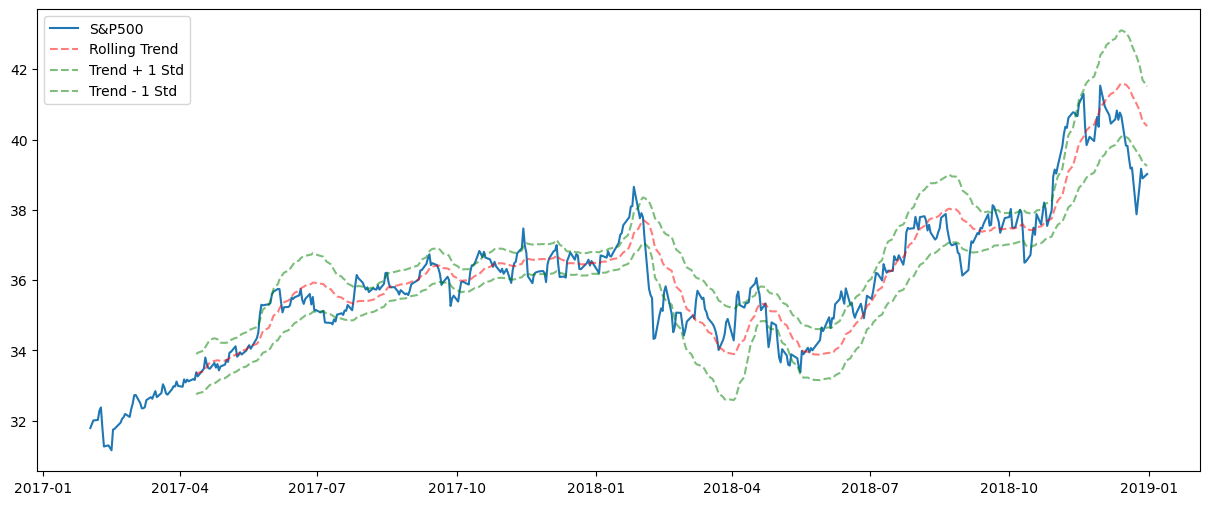

In [26]:
window = 50
# Perform rolling regression
rolling_ols = RollingOLS(
    endog=stock1_lr['Close'],       # Dependent variable
    exog=X,  # Independent variables + intercept
    window=window  # Rolling window size
)
rolling_res = rolling_ols.fit()

# Extract rolling regression trend and standard deviation
rolling_trend = rolling_res.params['Time']*X["Time"] + rolling_res.params['const']
rolling_std = stock1_lr['Close'].rolling(window=window).std()

# Plot the rolling regression trend with +/- standard deviation
plt.figure(figsize=(15, 6))
plt.plot(stock1_lr.index, stock1_lr['Close'], label="S&P500", alpha = 1)
plt.plot(stock1_lr.index, rolling_trend, 'r--', label="Rolling Trend", alpha = 0.51)
plt.plot(stock1_lr.index, rolling_trend + rolling_std, 'g--', label="Trend + 1 Std", alpha = 0.51)
plt.plot(stock1_lr.index, rolling_trend - rolling_std, 'g--', label="Trend - 1 Std",alpha = 0.51)
plt.legend()
plt.show()

## Cointegration 

If $X_1$, $X_2$, and $X_3$ are all I(1), and some linear combination 2.$X_1$ + $X_2$ + 0.$X_3$ = 2.$X_1$ + $X_2$ is I(0). In this case the time series are cointegrated.

Correlation and cointegration, while theoretically similar, are not the same. 

Correlation Without Cointegration: Two divergent series like normal I(1) series with different generating process means. 

Cointegration Without Correlation: Normally distributed series and a square wave.

### Pairs Trading

According to **the law of one price**, in a well-functioning economy, if two goods or assets are similar, they should have identical prices regardless of their location. This concept assumes that there are no factors such as transaction costs, transportation expenses, or other influences that affect the final price.

Within this framework, it is not feasible to buy a commodity in one place and sell it in another region because the production costs are the same in both areas.

In pairs trading your search for a pair of correlated assets where their prices are divergent, you short the overvalued asset and you long the undervalued asset and profit when the prices converge. Multiple reasons for divergence can be a natural disaster, corruption scandal, workers on strike, etc. The critical point is that this scenario is temporary.

The intuition here is that for some linear combination of the series, the result lacks much auto-covariance and is mostly noise. We can bet on the linear combination of time series as mean reverting or related to the same probability distribution and place trades accordingly.

#### Simple linear combination of two assets

In [27]:
Y = stock2_close - stock1_close
ADFTest(Y,regression = "ctt", significance_level=0.01)

ADF results of Close series:
ADF Statistic         -2.500808
p-value                0.568898
Lags Used              0.000000
Observations Used    501.000000 
Dickey Fuller Critical Values:
    1%: -4.3944
    5%: -3.8442
    10%: -3.5606

The time series is constant and quadratic trend nonstationary.



#### Engle-Granger method: Regression Model for cointegration

The regression model typically takes the form of $X_1$ = α + β$X_2$ + ε, where $X_1$ and $X_2$ represent the two time series, α is the intercept, β is the coefficient to be estimated, and ε is the error term. $X_1$ + $X_2$ = α + ε should be stationary.

Text(0, 0.5, 'Close')

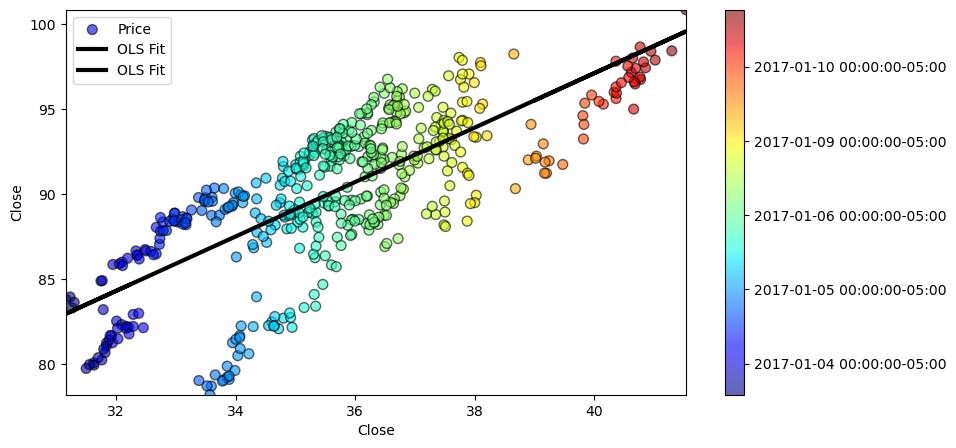

In [28]:
y = stock2_close
x = stock1_close
x = sm.add_constant(x)  # Add a constant term to the regression

model = sm.OLS(y, x)
results = model.fit()
alpha = results.params.values[0]
beta = results.params.values[1]
spreads = y - (x["Close"] * beta) # or results.resid
spreads.name = f"{stock2.info['symbol']} - ({beta:.2f}*{stock1.info['symbol']})"

plt.figure(figsize =(10,5))
cm = plt.get_cmap('jet')
sc = plt.scatter(x["Close"], y, s=50, c=x["Close"], cmap=cm, marker='o',
                 alpha=0.6,label='Price',edgecolor='k')
plt.plot(x, results.params[0] + x * results.params[1], '-', c='black', linewidth=3, label='OLS Fit')
plt.legend()
cb = plt.colorbar(sc)
cb.ax.set_yticklabels([str(p) for p in x.index])
plt.xlim(x["Close"].min(), x["Close"].max())
plt.ylim(y.min(), y.max())
plt.xlabel(stock1_close.name)
plt.ylabel(y.name)

Scaling has no effect on stationarity and is only used to bound the values.

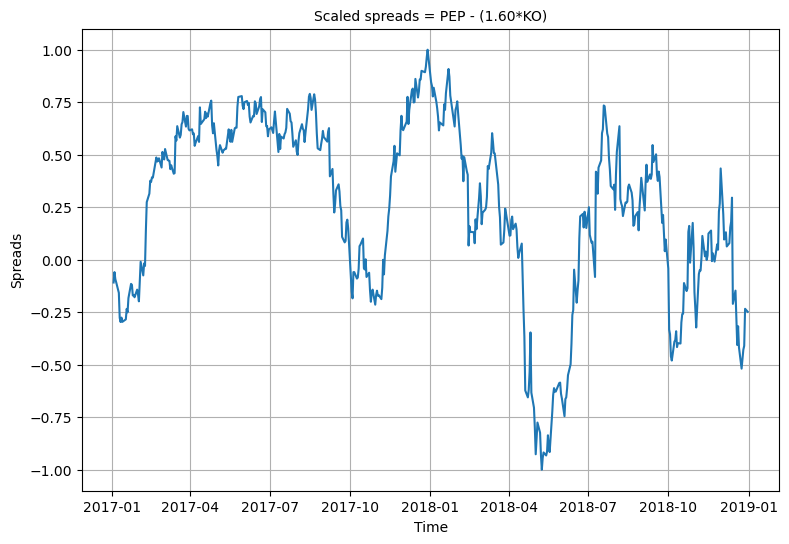

In [29]:
# Scale the residuals values using Min-Max scaling
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_spreads = scaler.fit_transform(spreads.values.reshape(-1, 1))

# Convert the scaled spread back to a pandas Series
scaled_spreads = pd.Series(scaled_spreads.flatten(), index=spreads.index)

# Plot the residuals
plt.figure(figsize=(9, 6))
plt.plot(scaled_spreads)
plt.title(
    f'Scaled spreads = {spreads.name}',
    fontsize=10,
)
plt.xlabel("Time")
plt.ylabel("Spreads")
plt.grid(True)
plt.show()

The spread α + ε is expected to be stationary.

In [30]:
ADFTest(spreads, regression = "ctt", significance_level=0.01, CointTest=True)

ADF results of PEP - (1.60*KO) series:
ADF Statistic         -2.681297
p-value                0.464980
Lags Used              0.000000
Observations Used    501.000000 
Dickey Fuller Critical Values:
    1%: -4.3944
    5%: -3.8442
    10%: -3.5606

The series is nonstationary. The linear combination of the time series is non-cointegrated over the same timeframe.


### Important Notes to consider

1. Remember as with anything else, you should not assume that because some set of assets have passed a cointegration test historically, they will continue to remain cointegrated. **Try out of sample testing**!

2. Make **many independent bets**: find many pairs of assets you hypothesize are cointegrated, and evenly distribute your dollars between them.

You have some extra knowledge about an economic link that leads you to believe that the pair is cointegrated, so you go out and test for the presence of cointegration. In this case you will incur **no multiple comparisons bias**. At the other end of the spectrum, you perform a search through hundreds of different securities for any viable pairs according to your test. In this case you will incur a very large amount of **multiple comparisons bias**.

The market drives the movement of so many securities that you often times might find two seemingingly cointegrated securities, but in reality they are not cointegrated and just both cointegrated with the market. This is known as a **confounding variable** and it is important to check for market involvement in any relationship you find.

3. **Lookahead Bias**: beta's computation is based on all of the data so if we were trying to make a decision about this spread in March, we'd actually be using information from the rest of the year which we wouldn't have had in March so it's an inaccurate representation of predictions. 

#### Rolling betas 

ADF results of Rolling Spreads series:
ADF Statistic       -7.038088e+00
p-value              6.568707e-08
Lags Used            1.000000e+00
Observations Used    4.760000e+02 
Dickey Fuller Critical Values:
    1%: -4.3956
    5%: -3.8449
    10%: -3.5610

The series is stationary. It suggests the presence of a cointegrating relationship between the linear combination of the time series over the same timeframe.


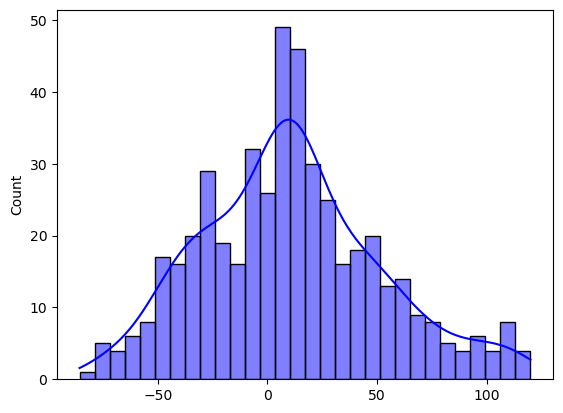

In [31]:
rolling_model = RollingOLS(
    endog=y,       # Dependent variable
    exog=x,  # Independent variables + intercept
    window=25         # Rolling window size
)

# Fit the rolling regression
rolling_results = rolling_model.fit()

# Extract rolling beta
rolling_betas =  rolling_results.params['Close']

rolling_spreads = y - rolling_betas * x["Close"]
rolling_spreads.dropna(inplace=True)
rolling_spreads.name = 'Rolling Spreads'
sns.histplot(rolling_spreads.values, color='blue', kde=True, bins=30)
ADFTest(rolling_spreads, regression = "ctt", significance_level=0.01, CointTest=True)

#### Faster way to check for cointegration

In [ ]:
# Perform cointegration test
score, pvalue, _ = coint(stock2_close, stock1_close)
print(pvalue)
# Interpret the results
if pvalue < 0.01:
    print("The two series are cointegrated.")
else:
    print("The two series are not cointegrated.")

0.22590555715542704
The two series are not cointegrated.


### Z-score

The z-score plays a pivotal role in identifying entry and exit points for pairs trading. However, much financial data is not normally distributed, and one must be very careful not to assume normality, nor any specific distribution when generating statistics. It could be the case that the true distribution of spreads was very fat-tailed and prone to extreme values. This could mess up our model and result in large losses.

<Axes: ylabel='Count'>

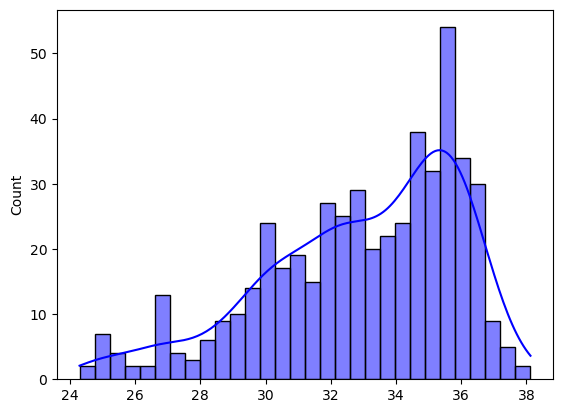

In [34]:
sns.histplot(spreads.values, color='blue', kde=True, bins=30)

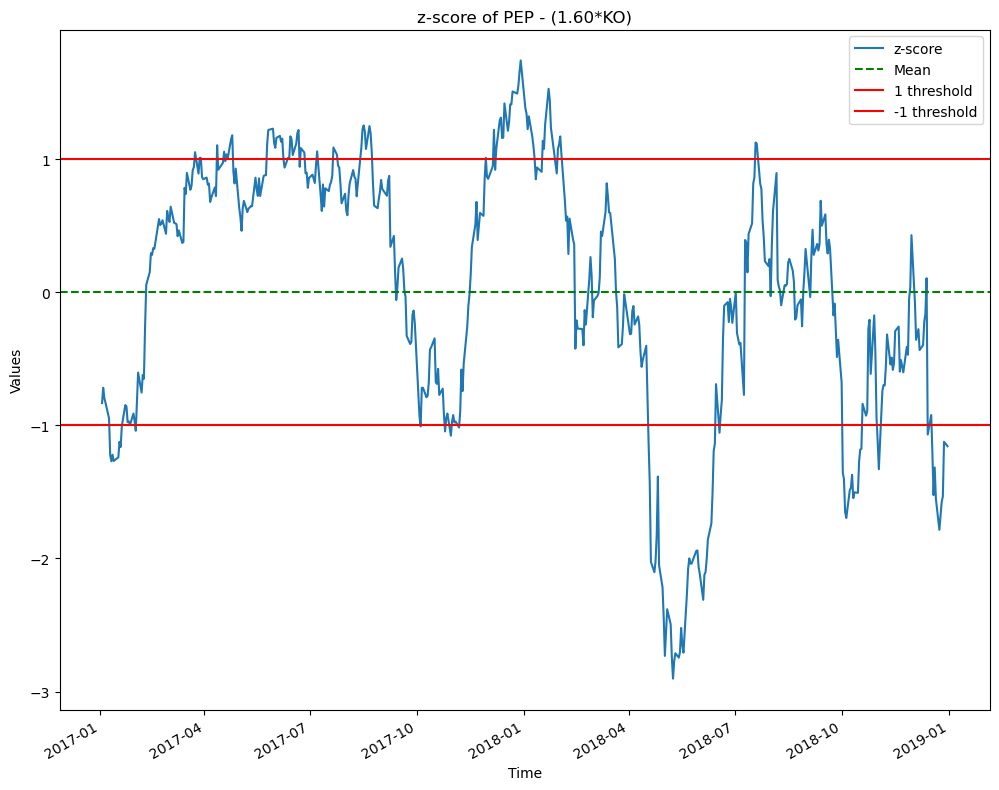

In [35]:
zscore = (spreads - np.mean(spreads)) / np.std(spreads)
plt.figure(figsize=(12, 10))
zscore.plot(label="z-score")
plt.axhline(zscore.mean(), color='green', linestyle='--', label='Mean')

plt.title(f"z-score of {spreads.name}")
plt.xlabel("Time")
plt.ylabel("Values")

plt.axhline(y=1, color="r", label="1 threshold")
plt.axhline(y=-1, color="r", label="-1 threshold")
plt.legend()

plt.show()

We decide when to initiate or close buying and selling positions based on certain thresholds that determines the divergence in price between the two financial instruments. (there is a high probability that the price reverts to zero.)

If the z-score exceeds a predefined threshold (e.g., +1 or -1), it suggests a significant deviation from the mean relationship. A positive z-score indicates the spread is higher than the mean, potentially signaling a short-selling opportunity for the overpriced asset and a long opportunity for the underpriced asset, and vice versa for a negative z-score.

More than 3-std threshold might mean that the cointegrated relationship is broken...

### Entry and Exit

For a long spread position: When the z-score drops below -1 after being above it, and there is currently no position, a long position of 1 unit in PEP (the losing stock) and place a short position of β units in KO (the winning stock).

For a short spread position: When the z-score rises above 1 after being below it, and there is currently no position, place a short position of 1 unit in PEP (the winning stock) and a long position of β units in KO (the losing stock).

Exit position: Whenever the z-score crosses 0 and there is no current position, exit the spread position.

### Simple strategy Implementation

#### Event driven backtest

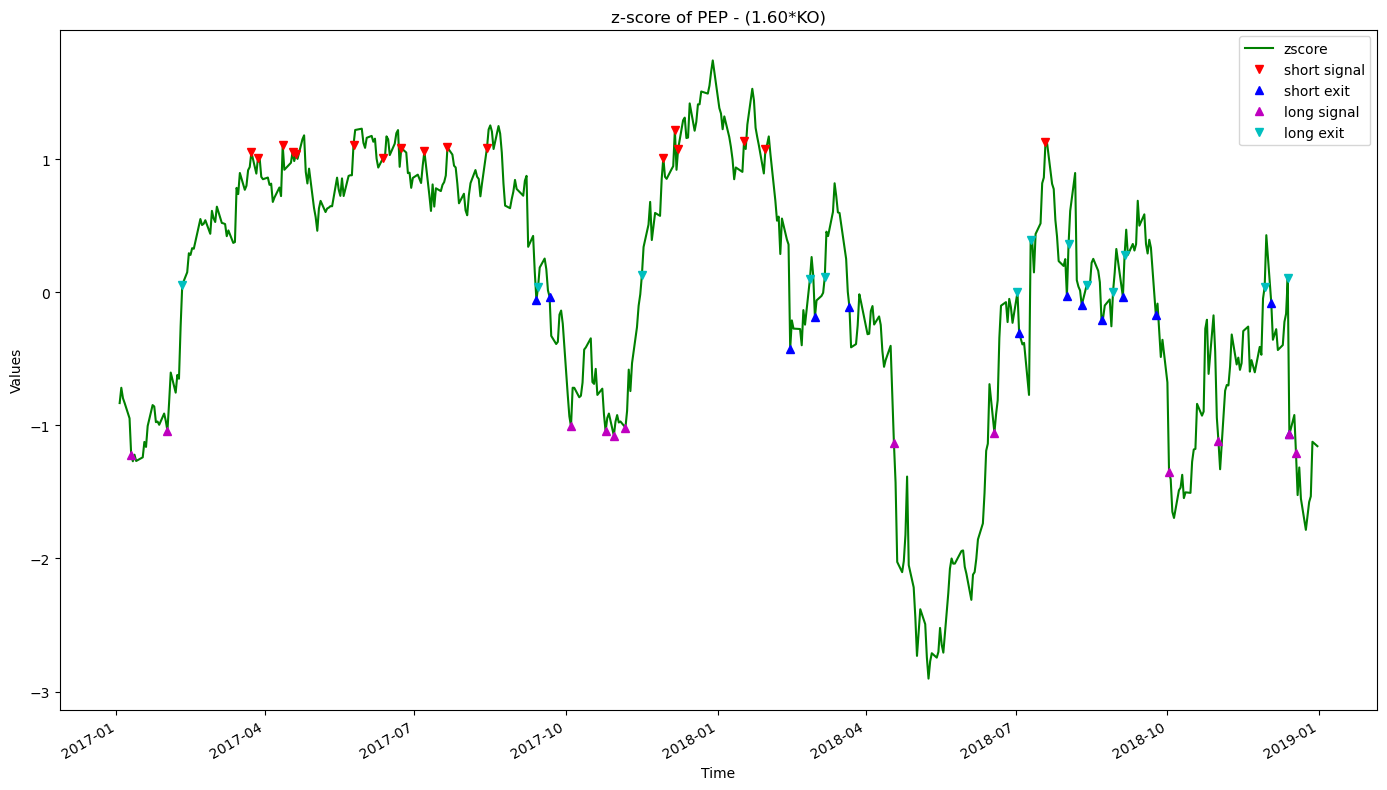

In [37]:
signals = pd.DataFrame()

signals["zscore"] = zscore
signal_entry = 1
signal_exit = 0

signals["short signal"] = signals["zscore"][(zscore > signal_entry) & (zscore.shift(1) < signal_entry)]
signals["short exit"] = signals["zscore"][(zscore < signal_exit) & (zscore.shift(1) > signal_exit)]

signals["long signal"] = signals["zscore"][(zscore < -signal_entry) & (zscore.shift(1) > -signal_entry)]
signals["long exit"] = signals["zscore"][(zscore > -signal_exit) & (zscore.shift(1) < -signal_exit)]

signals.plot(figsize =(17,10), style=['g', 'rv', 'b^', 'm^','cv'])
plt.title(f"z-score of {spreads.name}")
plt.xlabel("Time")
plt.ylabel("Values")
plt.legend()

In [38]:
btest = pd.DataFrame()

btest["stock2"] = stock2_close
btest["stock1"] = stock1_close

signal_entry = 1
signal_exit = 0

btest["short signal"] = (zscore > signal_entry) & (zscore.shift(1) < signal_entry)
btest["short exit"] = (zscore < signal_exit) & (zscore.shift(1) > signal_exit)

btest["long signal"] = (zscore < -signal_entry) & (zscore.shift(1) > -signal_entry)
btest["long exit"] = (zscore > -signal_exit) & (zscore.shift(1) < -signal_exit)

btest["beta"] = beta


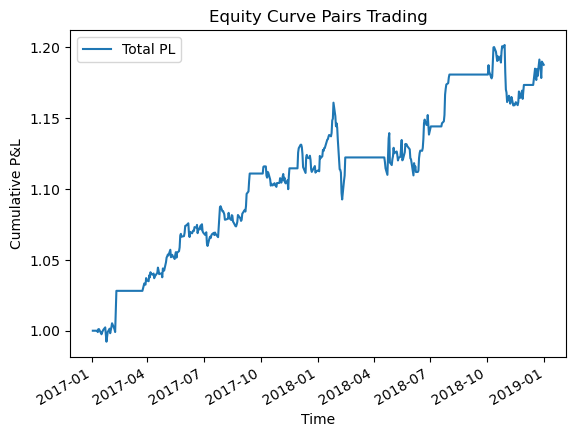

In [39]:
spread_side = None
counter = -1
backtest_result = []
for time, signals_stock in btest.iterrows():
    counter += 1
    stock2_, stock1_, short_signal, short_exit, long_signal, long_exit, beta = signals_stock
    if spread_side is None:
        return_stock2 = 0.0
        return_stock1 = 0.0
        backtest_result.append([time, return_stock2, return_stock1, spread_side])
        if short_signal is True:
            spread_side = "short"
        elif long_signal is True:
            spread_side = "long"
    elif spread_side == "long":
        return_stock2 = btest["stock2"][counter] / btest["stock2"][counter - 1] - 1.0
        return_stock1 = btest["stock1"][counter] / btest["stock1"][counter - 1] - 1.0
        backtest_result.append([time, return_stock2, -return_stock1*beta, spread_side])
        if long_exit is True:
            spread_side = None
    elif spread_side == "short":
        return_stock2 = btest["stock2"][counter] / btest["stock2"][counter - 1] - 1.0
        return_stock1 = btest["stock1"][counter] / btest["stock1"][counter - 1] - 1.0
        backtest_result.append([time, -return_stock2, return_stock1*beta, spread_side])
        if short_exit is True:
            spread_side = None

backtest_pandas = pd.DataFrame(backtest_result)

backtest_pandas.columns = ["Date", "stock2", "stock1", "Side"]
backtest_pandas["stock2 PL"] = np.cumprod(backtest_pandas["stock2"] + 1.0)
backtest_pandas["stock1 PL"] = np.cumprod(backtest_pandas["stock1"] + 1.0)
backtest_pandas["Total PL"] = (
    backtest_pandas["stock1 PL"] + backtest_pandas["stock2 PL"]
) / 2.0
backtest_pandas.index = backtest_pandas["Date"]

backtest_pandas[["Total PL"]].plot(label="Evolution Profit and Loss")
plt.title("Equity Curve Pairs Trading")
plt.xlabel("Time")
plt.ylabel("Cumulative P&L")
plt.legend()
plt.show()

#### Vectorized backtest

In [80]:
signal["creturn"].fillna(1.0)

Date
2017-01-03 00:00:00-05:00    1.000000
2017-01-04 00:00:00-05:00    1.000000
2017-01-05 00:00:00-05:00    1.000000
2017-01-06 00:00:00-05:00    1.000000
2017-01-09 00:00:00-05:00    1.000000
                               ...   
2018-12-24 00:00:00-05:00    1.097398
2018-12-26 00:00:00-05:00    1.090523
2018-12-27 00:00:00-05:00    1.085011
2018-12-28 00:00:00-05:00    1.095716
2018-12-31 00:00:00-05:00    1.093517
Name: creturn, Length: 502, dtype: float64

In [81]:
backtest_pandas[["Total PL"]]

,Total PL
Date,
2017-01-03 00:00:00-05:00,1.000000
2017-01-04 00:00:00-05:00,1.000000
2017-01-05 00:00:00-05:00,1.000000
2017-01-06 00:00:00-05:00,1.000000
2017-01-09 00:00:00-05:00,1.000000
...,...
2018-12-24 00:00:00-05:00,1.191307
2018-12-26 00:00:00-05:00,1.183794
2018-12-27 00:00:00-05:00,1.178286


<Axes: xlabel='Date'>

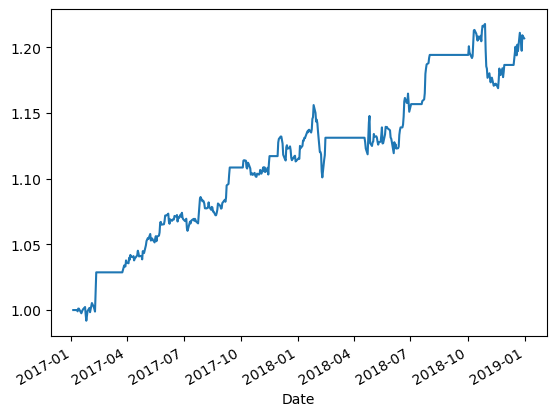

In [ ]:
signal = pd.DataFrame()

signal["zscore"] = zscore
signal_entry = 1
#* since signal_exit = 0
# signal_exit = 0
# signal["difference"] = signal["zscore"]- signal_exit
# signal["signal"] = np.where(signal["difference"] * signal["difference"].shift(1) < 0, 0, np.nan )


signal["signal"] = np.where(signal["zscore"] * signal["zscore"].shift(1) < 0, 0, np.nan )
signal["signal"] = np.where(signal["zscore"] > signal_entry, -1, signal["signal"] )
signal["signal"] = np.where(signal["zscore"] < -signal_entry, 1, signal["signal"])
signal["signal"] = signal["signal"].ffill().fillna(0)

signal["stock2_return"] = stock2_close.pct_change()
signal["stock1_return"] = stock1_close.pct_change()
signal["beta"] = beta
signal["return"] = signal["signal"].shift()*(signal["stock2_return"] - signal["beta"] * signal["stock1_return"])
signal["creturn"] = signal["return"].div(2).add(1).cumprod()
signal["creturn"].plot()

### Rolling betas and Z-score strategy Implementation

#### Event Driven Backtest

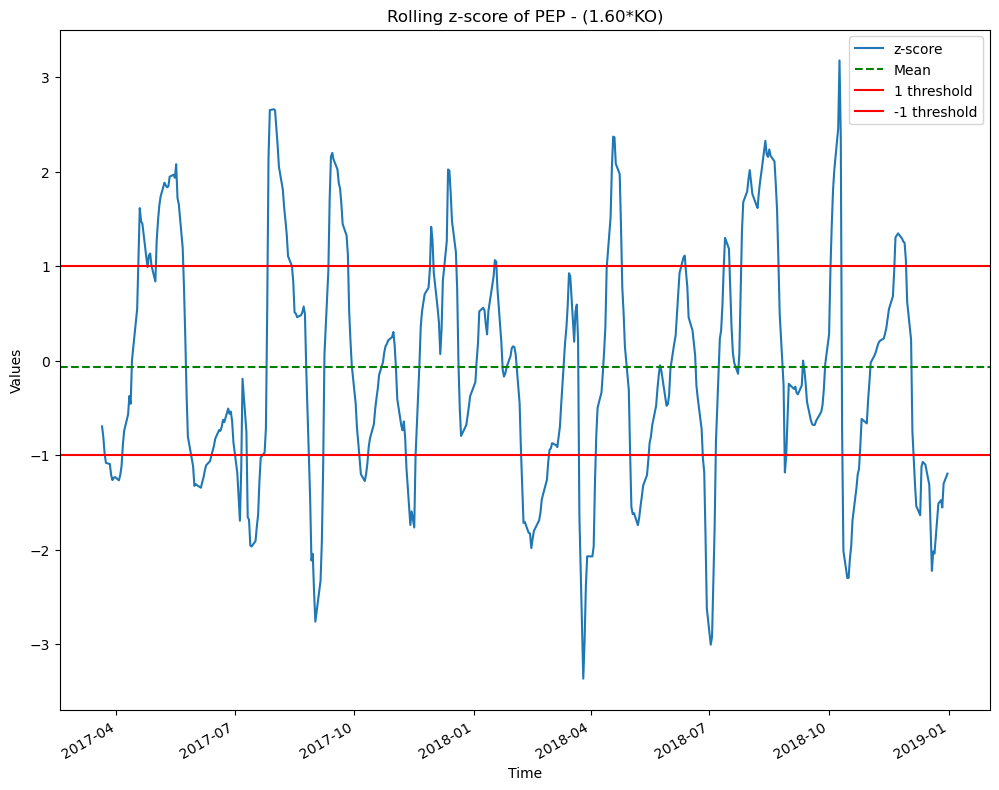

In [84]:
# Take a rolling 30 day standard deviation
std_30 = rolling_spreads.rolling(window=30).std()
std_30.name = 'std 30d'

# Get the 30 day moving average
spread_mavg30 = rolling_spreads.rolling(window=30).mean()
spread_mavg30.name = 'spread 30d mavg'

# Compute the z score for each day
rolling_zscore = (rolling_spreads - spread_mavg30) / std_30
rolling_zscore.dropna(inplace=True)

plt.figure(figsize=(12, 10))
rolling_zscore.plot(label="z-score")
plt.axhline(rolling_zscore.mean(), color='green', linestyle='--', label='Mean')

plt.title(f"Rolling z-score of {spreads.name}")
plt.xlabel("Time")
plt.ylabel("Values")

plt.axhline(y=1, color="r", label="1 threshold")
plt.axhline(y=-1, color="r", label="-1 threshold")
plt.legend()

plt.show()

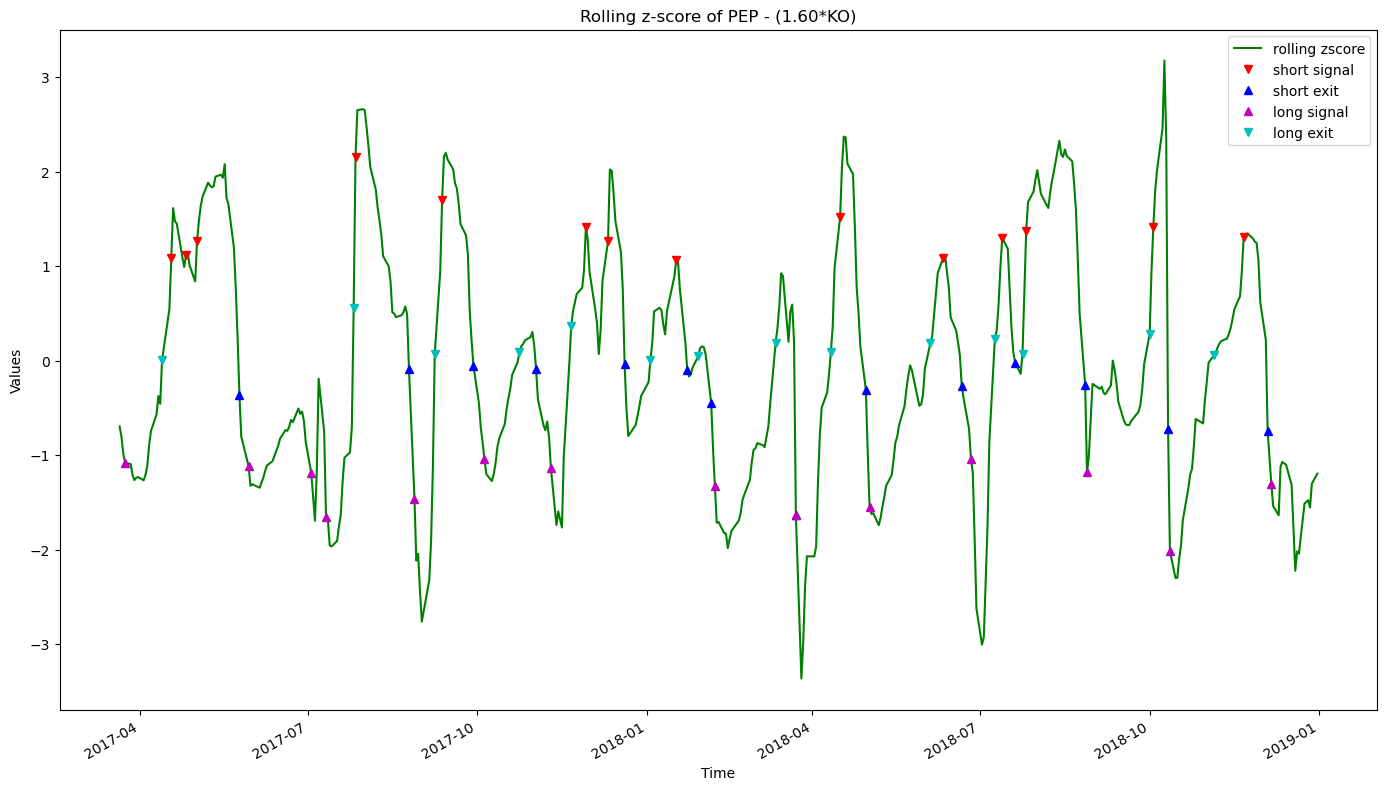

In [85]:
signals2 = pd.DataFrame()

signals2["rolling zscore"] = rolling_zscore
signal_entry2 = 1
signal_exit2 = 0

signals2["short signal"] = signals2["rolling zscore"][(rolling_zscore > signal_entry) & (rolling_zscore.shift(1) < signal_entry)]
signals2["short exit"] = signals2["rolling zscore"][(rolling_zscore < signal_exit) & (rolling_zscore.shift(1) > signal_exit)]

signals2["long signal"] = signals2["rolling zscore"][(rolling_zscore < -signal_entry) & (rolling_zscore.shift(1) > -signal_entry)]
signals2["long exit"] = signals2["rolling zscore"][(rolling_zscore > -signal_exit) & (rolling_zscore.shift(1) < -signal_exit)]

signals2.plot(figsize =(17,10), style=['g', 'rv', 'b^', 'm^','cv'])
plt.title(f"Rolling z-score of {spreads.name}")
plt.xlabel("Time")
plt.ylabel("Values")
plt.legend()

In [86]:
btest2 = pd.DataFrame()

btest2["stock2"] = stock2_close
btest2["stock1"] = stock1_close

signal_entry2 = 1
signal_exit2 = rolling_zscore.mean()

btest2["short signal"] = (rolling_zscore > signal_entry) & (rolling_zscore.shift(1) < signal_entry)
btest2["short exit"] = (rolling_zscore < signal_exit) & (rolling_zscore.shift(1) > signal_exit)

btest2["long signal"] = (rolling_zscore < -signal_entry) & (rolling_zscore.shift(1) > -signal_entry)
btest2["long exit"] = (rolling_zscore > -signal_exit) & (rolling_zscore.shift(1) < -signal_exit)

btest2['rollingbeta'] = rolling_betas

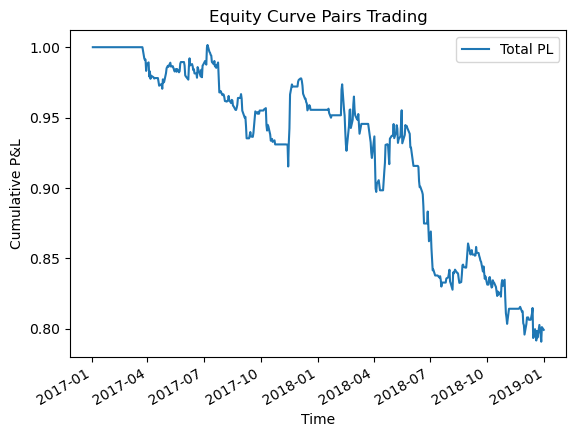

Cell execution time: 0.3311 seconds


In [133]:
from datetime import datetime

start_time = datetime.now()
spread_side = None
counter = -1
backtest_result2 = []
for time, signals_stock in btest2.iterrows():
    counter += 1
    stock2_, stock1_, short_signal, short_exit, long_signal, long_exit, rollingbeta= signals_stock
    if spread_side is None:
        return_stock2 = 0.0
        return_stock1 = 0.0
        backtest_result2.append([time, return_stock2, return_stock1, spread_side])
        if short_signal is True:
            spread_side = "short"
        elif long_signal is True:
            spread_side = "long"
    elif spread_side == "long":
        return_stock2 = btest2["stock2"][counter] / btest2["stock2"][counter - 1] - 1.0
        return_stock1 = btest2["stock1"][counter] / btest2["stock1"][counter - 1] - 1.0
        backtest_result2.append([time, return_stock2, -return_stock1*rollingbeta, spread_side])
        if long_exit is True:
            spread_side = None
    elif spread_side == "short":
        return_stock2 = btest2["stock2"][counter] / btest2["stock2"][counter - 1] - 1.0
        return_stock1 = btest2["stock1"][counter] / btest2["stock1"][counter - 1] - 1.0
        backtest_result2.append([time, -return_stock2, return_stock1*rollingbeta, spread_side])
        if short_exit is True:
            spread_side = None

backtest_pandas2 = pd.DataFrame(backtest_result2)

backtest_pandas2.columns = ["Date", "stock2", "stock1", "Side"]
backtest_pandas2["stock2 PL"] = np.cumprod(backtest_pandas2["stock2"] + 1.0)
backtest_pandas2["stock1 PL"] = np.cumprod(backtest_pandas2["stock1"] + 1.0)
backtest_pandas2["Total PL"] = (
    backtest_pandas2["stock1 PL"] + backtest_pandas2["stock2 PL"]
) / 2.0
backtest_pandas2.index = backtest_pandas2["Date"]

backtest_pandas2[["Total PL"]].plot(label="Evolution Profit and Loss")
plt.title("Equity Curve Pairs Trading")
plt.xlabel("Time")
plt.ylabel("Cumulative P&L")
plt.legend()
plt.show()

end_time = datetime.now()
event_time = (end_time - start_time).total_seconds()
print(f"Cell execution time: {event_time:.4f} seconds")

#### Vectorized Backtest

Time taken: 0.0772 seconds


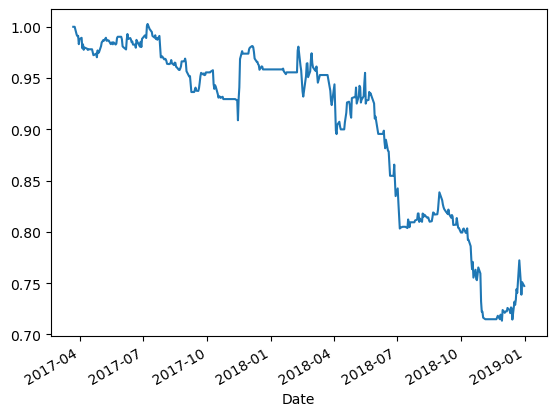

In [131]:
import time
start = time.time()
signal2 = pd.DataFrame()

signal2["rolling_zscore"] = rolling_zscore
signal2_entry = 1
#* since signal2_exit = 0
# signal2_exit = 0
# signal2["difference"] = signal2["rolling_zscore"]- signal2_exit
# signal2["signal"] = np.where(signal2["difference"] * signal2["difference"].shift(1) < 0, 0, np.nan )


signal2["signal"] = np.where(signal2["rolling_zscore"] * signal2["rolling_zscore"].shift(1) < 0, 0, np.nan )
signal2["signal"] = np.where(signal2["rolling_zscore"] > signal2_entry, -1, signal2["signal"] )
signal2["signal"] = np.where(signal2["rolling_zscore"] < -signal2_entry, 1, signal2["signal"])
signal2["signal"] = signal2["signal"].ffill().fillna(0)


signal2["stock2_return"] = stock2_close.pct_change()
signal2["stock1_return"] = stock1_close.pct_change()
signal2["rolling_betas"] = rolling_betas
signal2["return"] = signal2["signal"].shift()*(signal2["stock2_return"] - signal2["rolling_betas"] * signal2["stock1_return"])
signal2["creturn"] = signal2["return"].div(2).add(1).cumprod()
signal2["creturn"].plot()
end = time.time()
v_time = end - start
print(f"Time taken: {v_time:.4f} seconds")


In [134]:
event_time/v_time

4.289857890208604